In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.linalg import svd
import numpy as np
import matplotlib.patches as mpatches
from wordcloud import WordCloud
import plotly.express as px
import re
import itertools

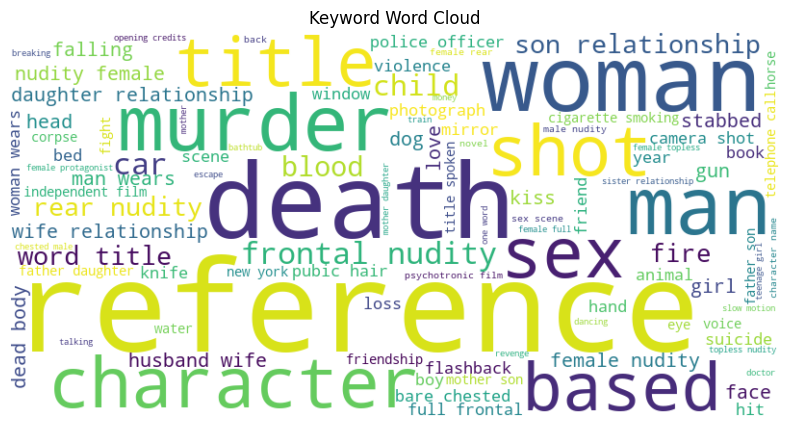

In [9]:
# Load the dataset
file_path = "./European_data_2000.csv"  # Update the path if needed
df = pd.read_csv(file_path)

# Convert columns to appropriate data types
df["releaseYear"] = df["releaseYear"].astype("Int64")
df["runtimeMinutes"] = df["runtimeMinutes"].astype("Int64")
df["numberOfVotes"] = df["numberOfVotes"].astype("Int64")
df["imdbRating"] = df["imdbRating"].astype(float)

# Ensure 'keywords' column is string type and handle NaN values
df["keywords"] = df["keywords"].fillna("").astype(str)

# Filter movies with IMDb rating over 7
high_rated_df = df[df["imdbRating"] > 7]

# Combine all keywords into a single string
all_keywords = " ".join(df["keywords"])

# Generate the word cloud
wordcloud = WordCloud(
    width=800, height=400,
    background_color="white",
    colormap="viridis",
    max_words=100
).generate(all_keywords)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Keyword Word Cloud")
plt.show()

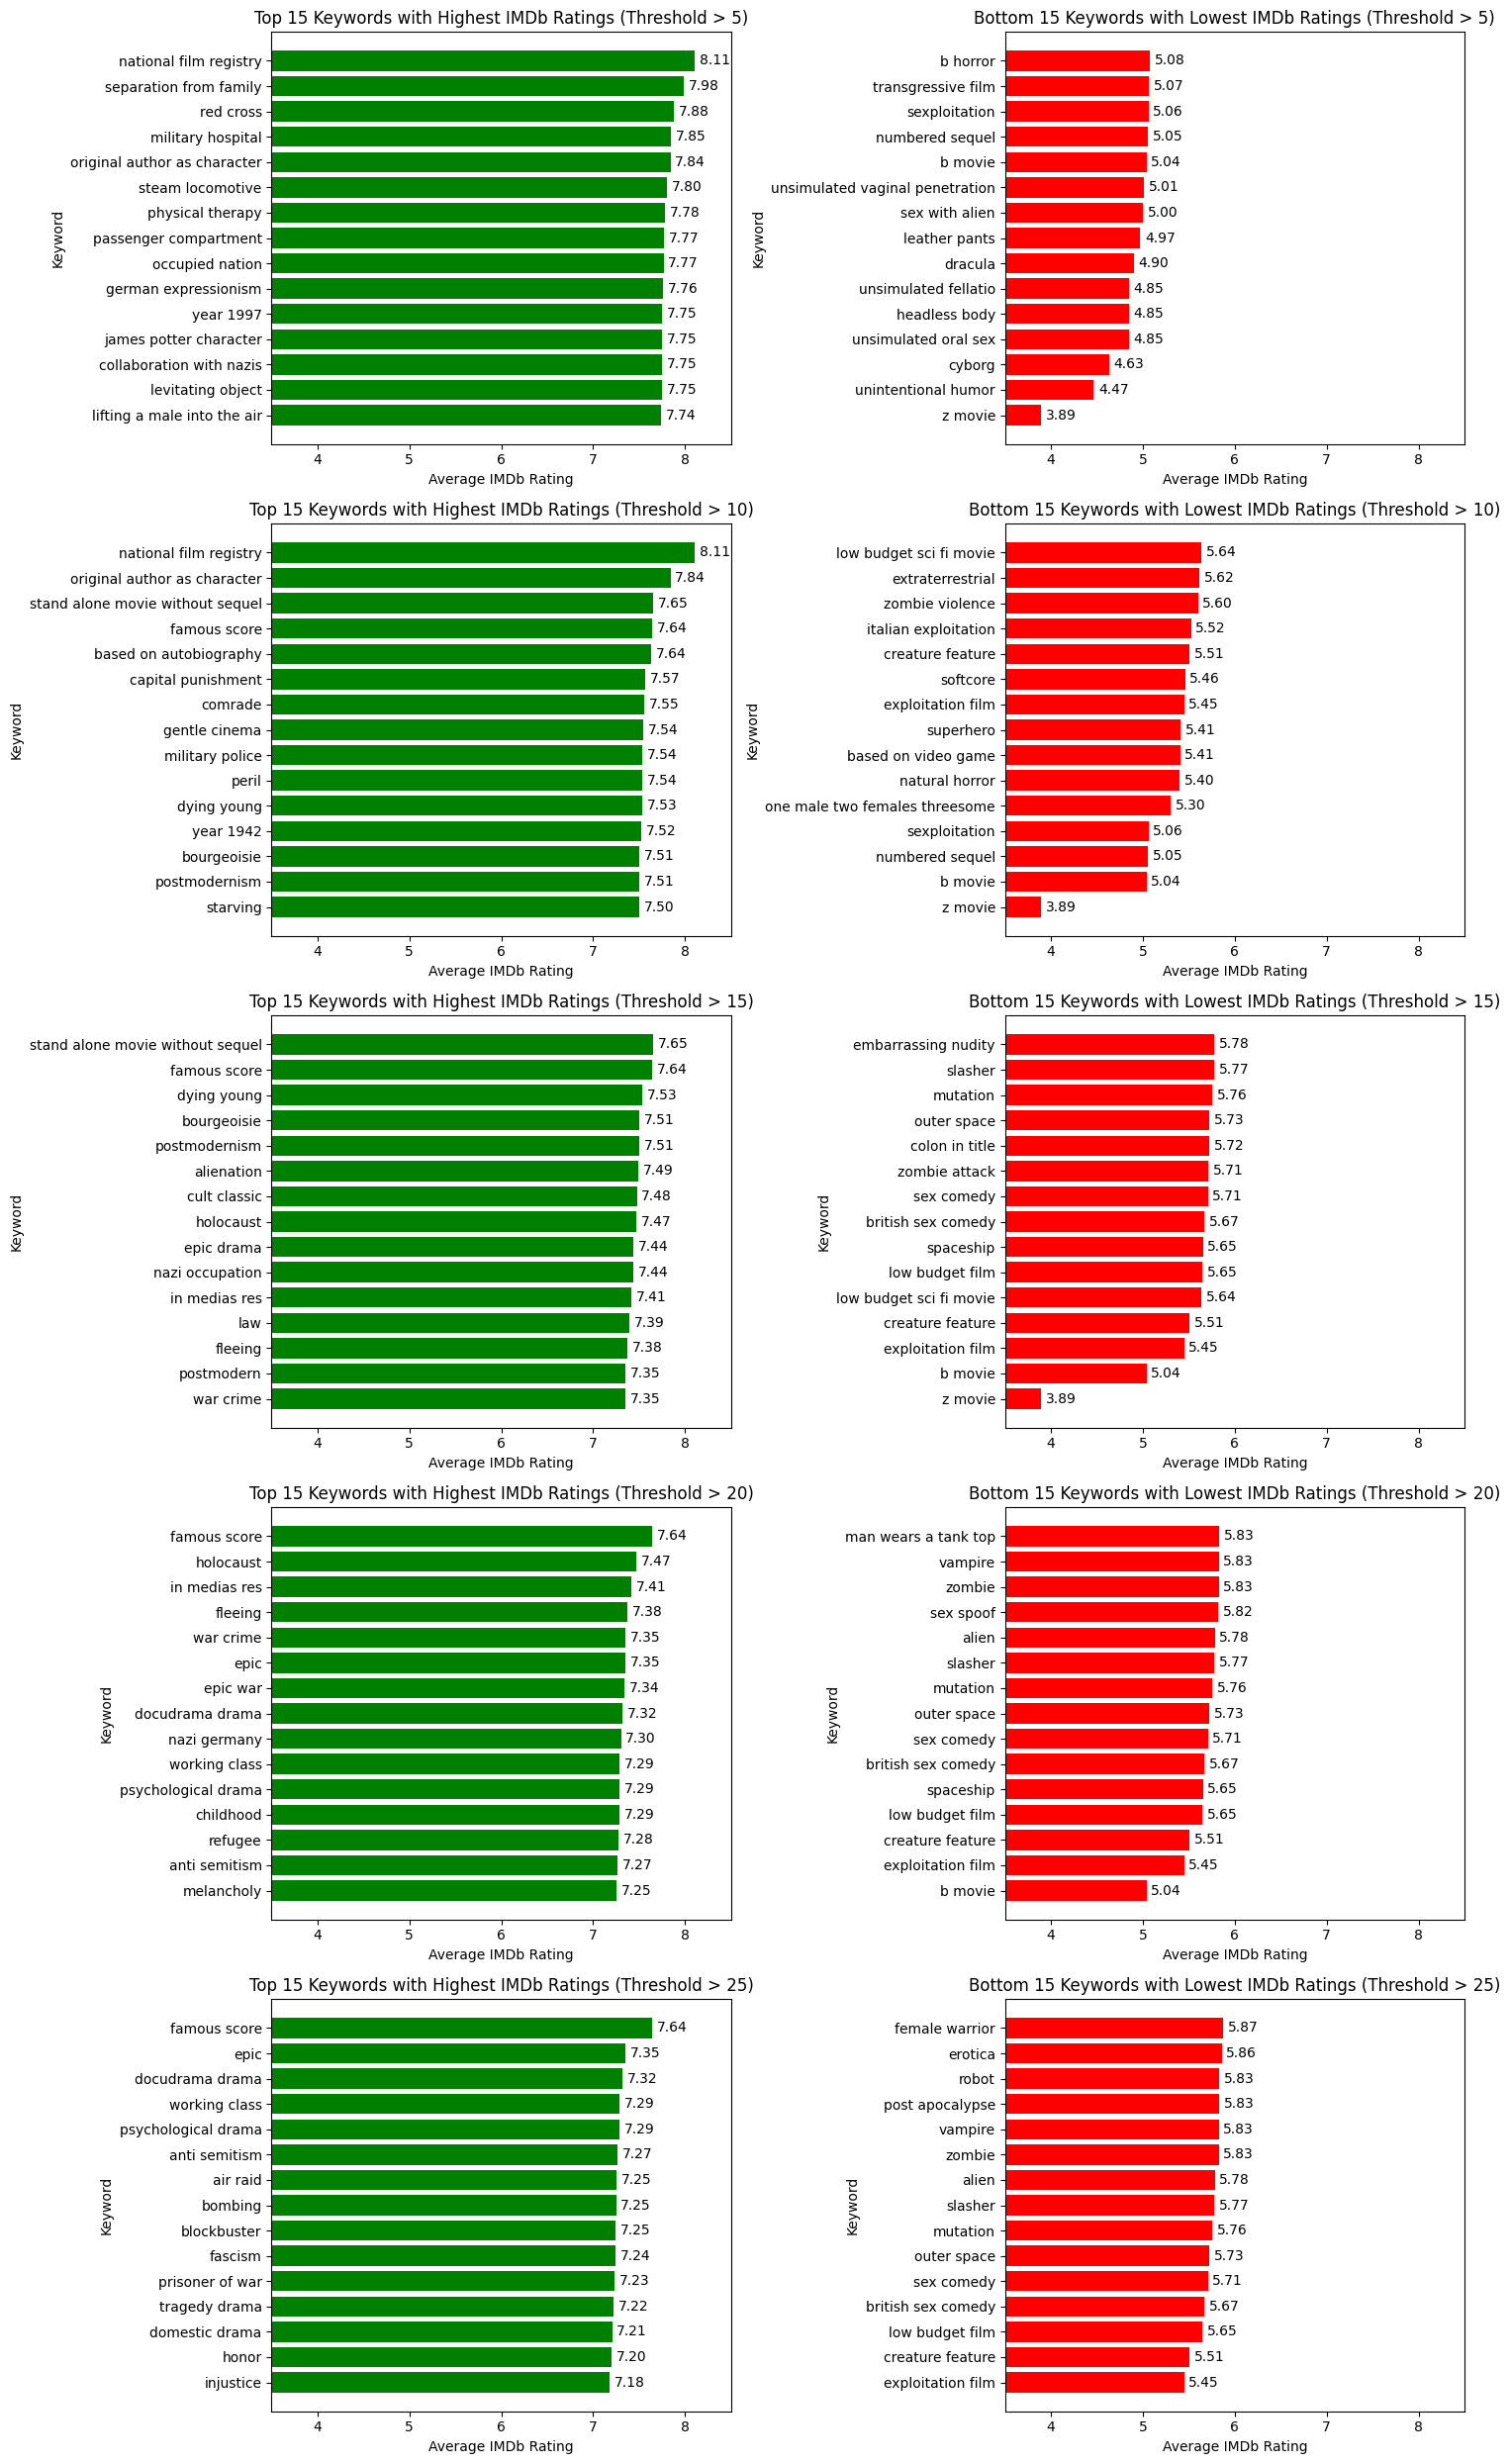

In [10]:
from collections import defaultdict

# Create a dictionary to store keyword ratings
keyword_ratings = defaultdict(list)

# Iterate through each row and assign IMDb rating to its keywords
for _, row in df.iterrows():
    keywords = row["keywords"].split(", ")  # Split keywords into a list
    for keyword in keywords:
        keyword_ratings[keyword].append(row["imdbRating"])

# Define thresholds for filtering keywords
thresholds = [5, 10, 15, 20, 25]

# Create subplots for multiple plots
fig, axes = plt.subplots(len(thresholds), 2, figsize=(15, 5 * len(thresholds)))

for i, threshold in enumerate(thresholds):
    # Calculate the average IMDb rating for each keyword
    keyword_avg_ratings = {k: sum(v) / len(v) for k, v in keyword_ratings.items() if len(v) > threshold}

    # Convert to DataFrame and sort by rating
    keyword_df = pd.DataFrame(keyword_avg_ratings.items(), columns=["Keyword", "Average IMDb Rating"])
    keyword_df = keyword_df.sort_values(by="Average IMDb Rating", ascending=False)

    # Display top and bottom 15 keywords
    top_keywords = keyword_df.head(15)
    bottom_keywords = keyword_df.tail(15)

    # Plot top 15 keywords
    ax_top = axes[i, 0]
    ax_top.barh(top_keywords["Keyword"], top_keywords["Average IMDb Rating"], color="green")
    ax_top.set_xlabel("Average IMDb Rating")
    ax_top.set_ylabel("Keyword")
    ax_top.set_title(f"Top 15 Keywords with Highest IMDb Ratings (Threshold > {threshold})")
    ax_top.invert_yaxis()
    ax_top.set_xlim(3.5, 8.5)  # Adjust based on your data
    for idx, val in enumerate(top_keywords["Average IMDb Rating"]):
        ax_top.text(val + 0.05, idx, f"{val:.2f}", va="center")

    # Plot bottom 15 keywords
    ax_bottom = axes[i, 1]
    ax_bottom.barh(bottom_keywords["Keyword"], bottom_keywords["Average IMDb Rating"], color="red")
    ax_bottom.set_xlabel("Average IMDb Rating")
    ax_bottom.set_ylabel("Keyword")
    ax_bottom.set_title(f"Bottom 15 Keywords with Lowest IMDb Ratings (Threshold > {threshold})")
    ax_bottom.invert_yaxis()
    ax_bottom.set_xlim(3.5, 8.5)  # Same range for consistency
    for idx, val in enumerate(bottom_keywords["Average IMDb Rating"]):
        ax_bottom.text(val + 0.05, idx, f"{val:.2f}", va="center")


# Adjust layout and display plots
plt.tight_layout()
plt.show()

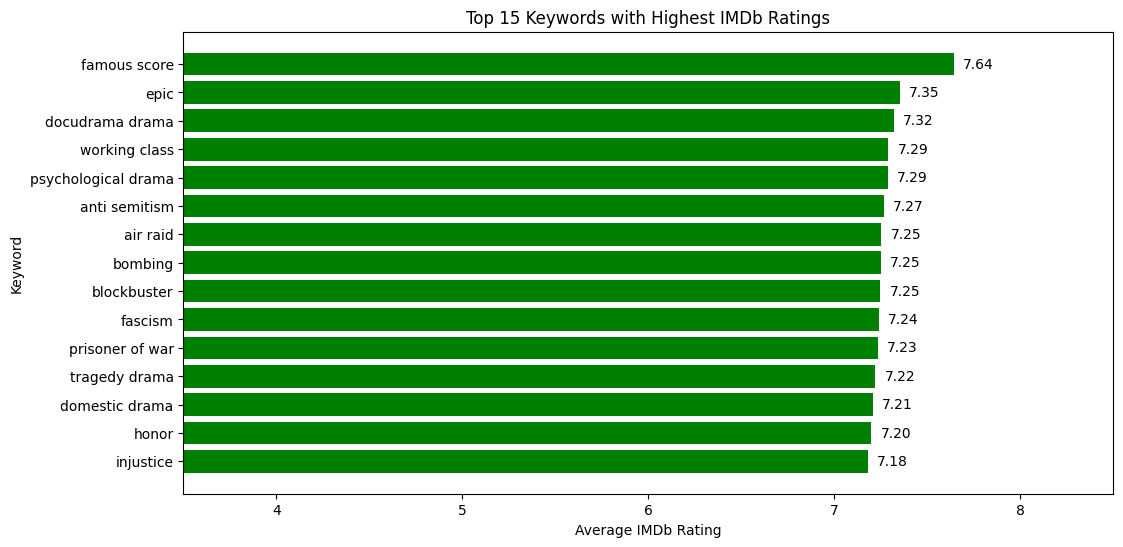

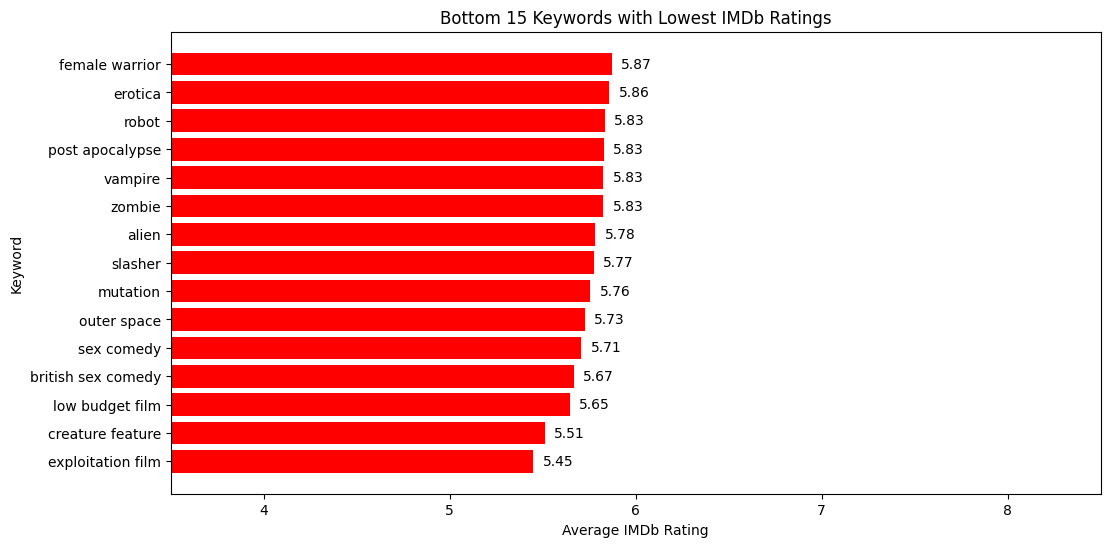

In [11]:
# Plot top 15 keywords
plt.figure(figsize=(12, 6))
plt.barh(top_keywords["Keyword"], top_keywords["Average IMDb Rating"], color="green")
plt.xlabel("Average IMDb Rating")
plt.ylabel("Keyword")
plt.title("Top 15 Keywords with Highest IMDb Ratings")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.xlim(3.5, 8.5)  # Narrowed x-axis range

# Add value labels
for i, val in enumerate(top_keywords["Average IMDb Rating"]):
    plt.text(val + 0.05, i, f"{val:.2f}", va="center")

plt.show()

# Plot bottom 15 keywords
plt.figure(figsize=(12, 6))
plt.barh(bottom_keywords["Keyword"], bottom_keywords["Average IMDb Rating"], color="red")
plt.xlabel("Average IMDb Rating")
plt.ylabel("Keyword")
plt.title("Bottom 15 Keywords with Lowest IMDb Ratings")
plt.gca().invert_yaxis()
plt.xlim(3.5, 8.5)

# Add value labels
for i, val in enumerate(bottom_keywords["Average IMDb Rating"]):
    plt.text(val + 0.05, i, f"{val:.2f}", va="center")

plt.show()


✅ a. Genre and Keyword Intersection

* Cross-tab: Which keywords dominate within each genre?

* Heatmap: Average rating by genre–keyword pair (e.g., “war” in “drama” scores better than “war” in “sci-fi”).

✅ b. Temporal Trends

Use releaseYear to show: 
→ Rise/fall of themes (e.g., war, horror, LGBTQ+, etc.)
→ IMDb rating trendlines per theme/genre/keyword.

✅ c. “Three Bastards” Archetype Testing

* Manually tag 10–15 plotShort entries with Denmark/Sweden/Norway bastard types.

* Plot average rating and keyword frequency per archetype (can be fun and interpretive).

# IF I HAVE TIME: 
* Use unsupervised methods to group stories by theme or tone. Match clusters with audience rating trends. Also see if I can automate 3 bastards archetype

# Genre and Keyword Intersection

In [16]:
# Build a nested dictionary of {genre: {keyword: [ratings]}}
genre_keyword_ratings = defaultdict(lambda: defaultdict(list))

for _, row in df.iterrows():
    genres = row["genres"].split(", ")
    keywords = row["keywords"].split(", ")
    rating = row["imdbRating"]
    
    for genre, keyword in itertools.product(genres, keywords):
        if genre and keyword:
            genre_keyword_ratings[genre][keyword].append(rating)
            
# Compute average ratings
genre_keyword_avg = {
    genre: {
        keyword: np.mean(ratings)
        for keyword, ratings in keywords.items()
        if len(ratings) >= 3
    }
    for genre, keywords in genre_keyword_ratings.items()
}

# Convert to DataFrame
genre_keyword_df = pd.DataFrame(genre_keyword_avg).fillna(0)

# Filter to frequently occurring keywords only
keyword_counts = df["keywords"].str.split(", ").explode().value_counts()
top_keywords = keyword_counts[keyword_counts >= 10].index
genre_keyword_df_filtered = genre_keyword_df.loc[genre_keyword_df.index.intersection(top_keywords)]

# Limit rows to keep the heatmap clean
genre_keyword_df_plot = genre_keyword_df_filtered.head(30)

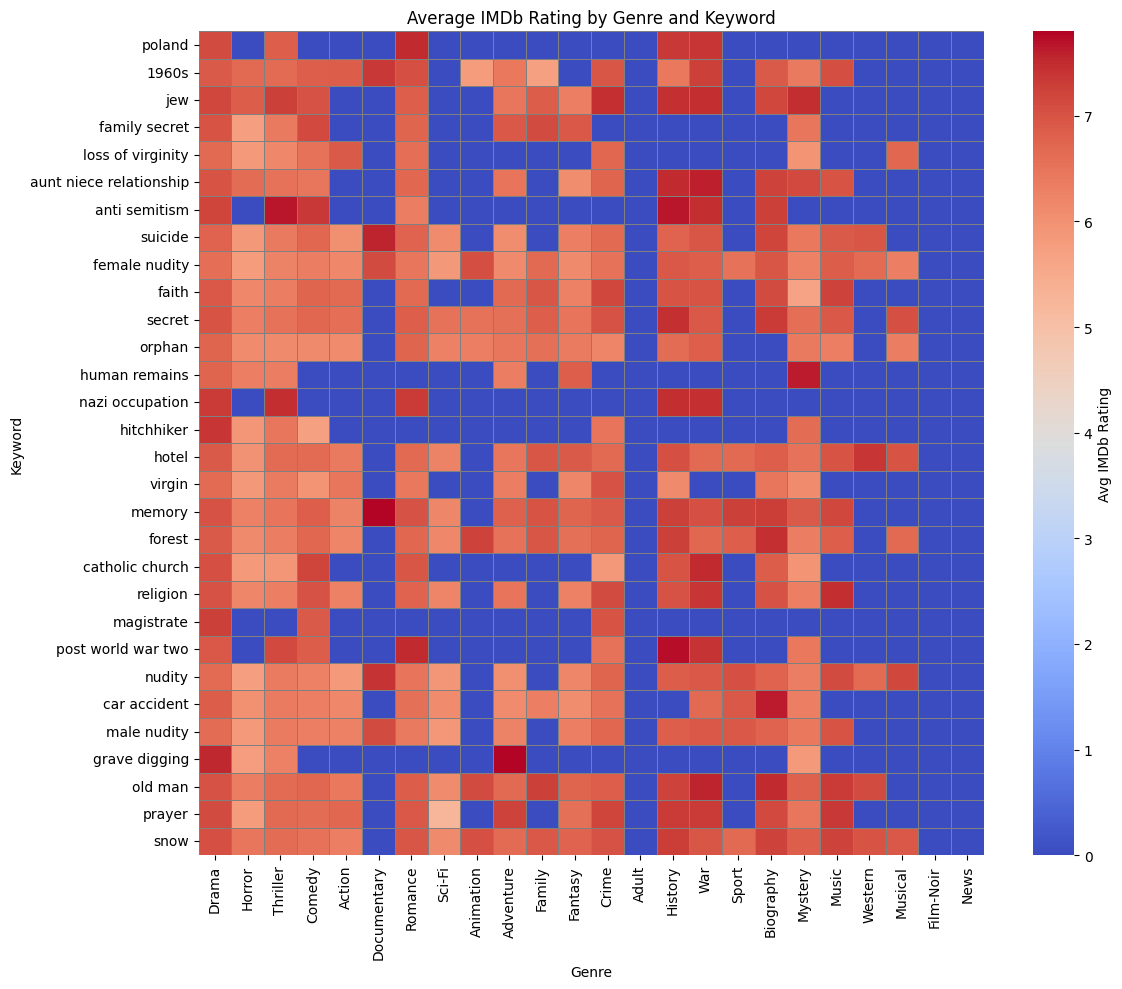

In [17]:
# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(genre_keyword_df_plot, annot=False, cmap="coolwarm", linewidths=0.5, linecolor='gray', cbar_kws={"label": "Avg IMDb Rating"})
plt.title("Average IMDb Rating by Genre and Keyword")
plt.xlabel("Genre")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()